In [1]:
"""Train a model on synthetic data and evaluate its fairness and performance on real data.
Args:
    plot_path: path to save the plot
    sythetic_dir: directory of synthetic data
    real_dir: directory of real data
    sensitive_col_id: column id of sensitive attribute
    model: classifier
"""

import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from wellearn.fairness import eval_clf_fairness, FairSklearnModel
from wellearn.fairness import fairness_versus_performance, dpr_and_acc
import matplotlib.pyplot as plt

In [2]:
##########################################################################################
# Part 0 - Arguments
plot_path = './plots/'
synthetic_dir = '../exp/depression/check/'
real_dir = '../data/depression/'
sensitive_col_id = 0  # column index of sensitive feature in X_cat
model = LogisticRegression(solver='lbfgs', max_iter=5000)

In [3]:
##########################################################################################
# Part 1 - Data

# read synthetic data
synthetic_X_num_train = np.load(synthetic_dir + 'X_num_train.npy', allow_pickle=True)
synthetic_X_cat_train = np.load(synthetic_dir + 'X_cat_train.npy', allow_pickle=True)

# normalize data, encode categorical data to ordinal values, and select sensitive feature
enc = OrdinalEncoder()
synthetic_X_cat_train = enc.fit_transform(synthetic_X_cat_train)
synthetic_z_train = synthetic_X_cat_train[:, sensitive_col_id]

# get sythetic y, X
synthetic_y_train = np.load(synthetic_dir + 'y_train.npy')
synthetic_X_train = np.concatenate((synthetic_X_num_train, synthetic_X_cat_train), axis=1)

# read real data
real_X_num_val = np.load(real_dir + 'X_num_val.npy', allow_pickle=True)
real_X_cat_val = np.load(real_dir + 'X_cat_val.npy', allow_pickle=True)

# normalize data, encode categorical data to ordinal values, and select sensitive feature
real_X_cat_val = enc.transform(real_X_cat_val)
real_z_val = real_X_cat_val[:, sensitive_col_id]

# get real y, X
real_y_val = np.load(real_dir + 'y_val.npy')
real_X_train = np.concatenate((real_X_num_val, real_X_cat_val), axis=1)

In [4]:
# test simple classifier
clf = LogisticRegression(solver='lbfgs', max_iter=5000)
clf.fit(synthetic_X_train, synthetic_y_train)
clf.score(real_X_train, real_y_val)

0.9381818181818182

In [3]:
##########################################################################################
# Part 2 - Classifier and fairness metric

stats = {}
metrics = {}

# Unmitigated
print("Unmitigated")
fairmodel = FairSklearnModel(model)
fairmodel.fit_raw(synthetic_X_train, synthetic_y_train)
metrics['unmitigated'] = eval_clf_fairness(real_y_val, fairmodel.predict(real_X_train), real_z_val)
stats['unmitigated'] = dpr_and_acc(real_y_val, fairmodel.predict(real_X_train), real_z_val)

# Exponentiated gradient
print("Exponentiated gradient")
fairmodel = FairSklearnModel(model)
fairmodel.fit_exp_grad(synthetic_X_train, synthetic_y_train, synthetic_z_train)
metrics['exp_grad'] = eval_clf_fairness(real_y_val, fairmodel.predict(real_X_train), real_z_val)
stats['exp_grad'] = dpr_and_acc(real_y_val, fairmodel.predict(real_X_train), real_z_val)

# Grid search
print("Grid search")
fairmodel = FairSklearnModel(model)
fairmodel.fit_grid_search(synthetic_X_train, synthetic_y_train, synthetic_z_train)
metrics['grid_search'] = eval_clf_fairness(real_y_val, fairmodel.predict(real_X_train), real_z_val)
stats['grid_search'] = dpr_and_acc(real_y_val, fairmodel.predict(real_X_train), real_z_val)

# Threshold optimizer
print("Threshold optimizer")
fairmodel = FairSklearnModel(model)
fairmodel.fit_threshold_optimizer(synthetic_X_train, synthetic_y_train, synthetic_z_train)
metrics['threshold_optimizer'] = eval_clf_fairness(real_y_val, 
                                                   fairmodel.predict(real_X_train, list(real_z_val)), 
                                                   real_z_val)
stats['threshold_optimizer'] = dpr_and_acc(real_y_val, 
                                           fairmodel.predict(real_X_train, list(real_z_val)), 
                                           real_z_val)

Unmitigated
Exponentiated gradient
Grid search
Threshold optimizer


In [4]:
##########################################################################################
# Part 3 - Visualize results

fairness_options = ["selection rate", "false negative rate"]
performance_options = ["accuracy", "recall"]
fairness_frame, performance_frame = fairness_versus_performance(
    metrics, fairness_options, performance_options
)

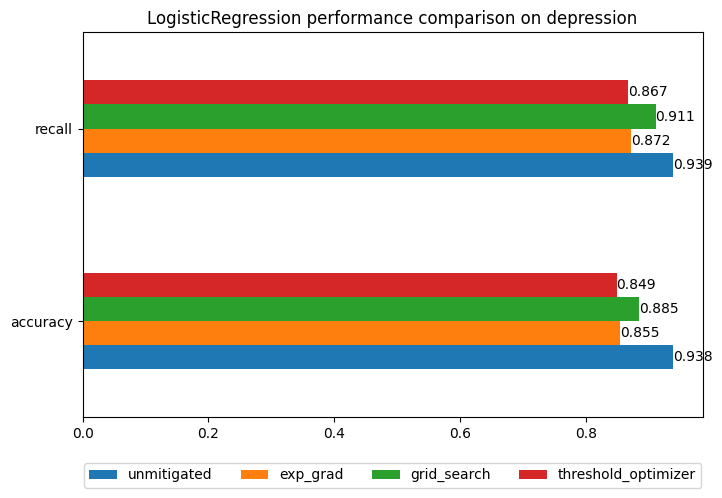

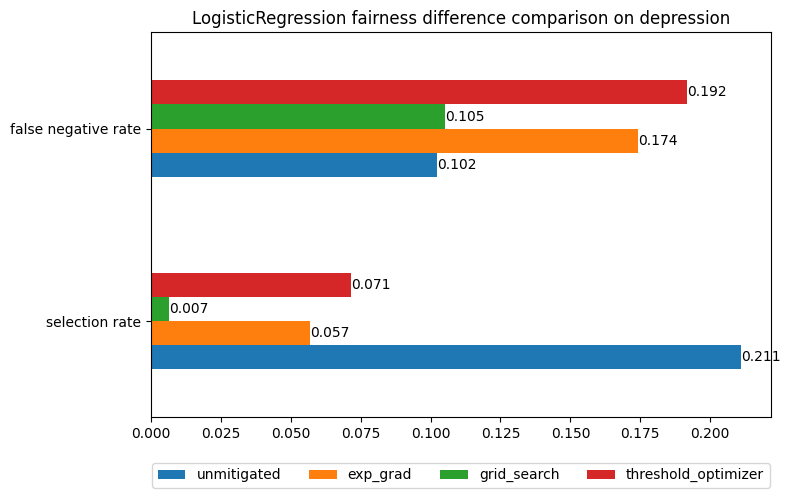

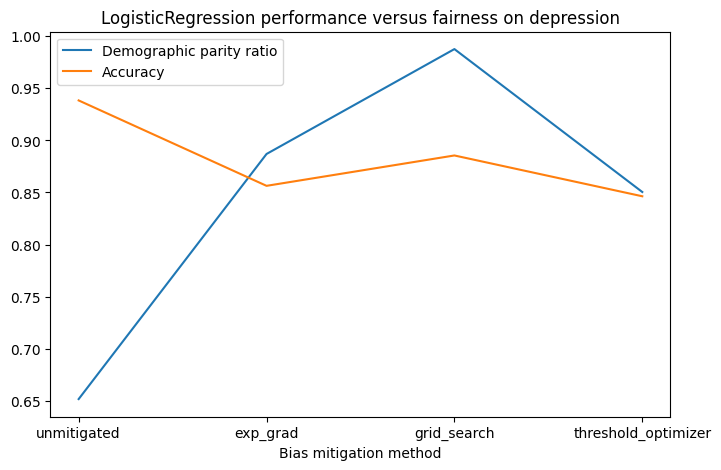

In [5]:
# Performance
model_name = type(model).__name__
dataset_name = real_dir.split('/')[2]
figsize = (8, 5)
title = f'{model_name} performance comparison on {dataset_name}'
fig = performance_frame.plot(figsize=figsize, kind='barh', title=title, rot=0)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
for container in fig.containers:
    fig.bar_label(container, label_type='edge', color='black', fmt='%.3f')
fig.get_figure().savefig(plot_path + title + '.png', bbox_inches='tight')

# Fairness
title = f'{model_name} fairness difference comparison on {dataset_name}'
fig = fairness_frame.plot(figsize=figsize, kind='barh', title=title, rot=0)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
for container in fig.containers:
    fig.bar_label(container, label_type='edge', color='black', fmt='%.3f')
fig.get_figure().savefig(plot_path + title + '.png', bbox_inches='tight')

# Performance versus fairness
title = f'{model_name} performance versus fairness on {dataset_name}'
terms = []
dpr = []
acc = []
for key, val in stats.items():
    terms.append(key)
    dpr.append(val[0])
    acc.append(val[1])
fig, ax = plt.subplots(figsize=figsize)
ax.plot(terms, dpr, label='Demographic parity ratio')
ax.plot(terms, acc, label='Accuracy')
ax.set_xlabel('Bias mitigation method')
ax.legend()
ax.set_title(title)
fig.get_figure().savefig(plot_path + title + '.png', bbox_inches='tight')